# 卸売業者のデータ分析
クラスタリングの利用法を学ぶために、Wholesale customers Data Setを使用します。


UCI Machine Learning Repository: Wholesale customers Data Set


Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

In [1]:
import pandas as pd
import numpy as np

full_df = pd.read_csv('Wholesale customers data.csv')
full_df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [2]:
data_df = full_df.drop(['Channel','Region'], axis=1)
data_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## 次元削減

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data_df)
data_pca = pca.transform(data_df)

In [4]:
data_pca.shape

(440, 2)

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


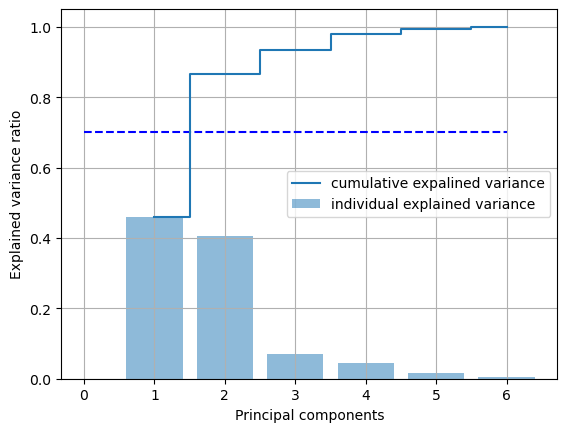

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=None)
pca = pca.fit(data_df)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

## 元々の散布図

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.figure(figsize=(8, 4))

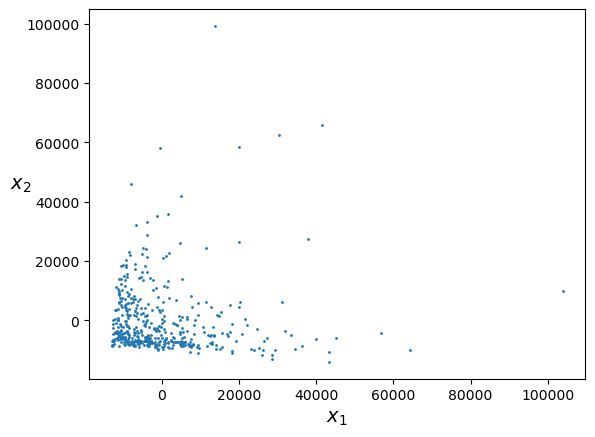

<Figure size 800x400 with 0 Axes>

In [7]:
plot_clusters(data_pca)
plt.show();

クラスタも何も....

In [8]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data_pca)
                for k in range(2, 30)]
inertias = [model.inertia_ for model in kmeans_per_k]

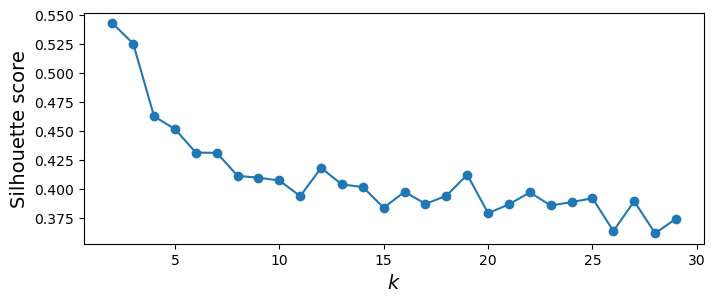

In [9]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(data_pca, model.labels_)
                     for model in kmeans_per_k]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 30), silhouette_scores, marker='o')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show();

最適なクラスタは2, 次点で3になる。

In [10]:
import matplotlib.pyplot as plt
def plot_data(clusterer, X):
    for i in (np.unique(clusterer.labels_)):
        in_cluster = clusterer.labels_ == i
        plt.scatter(X[in_cluster][:, 0], X[in_cluster][:, 1], s=3, label=i) 
        plt.legend()

# 重心プロット君
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=10, linewidths=10,
                color=cross_color, zorder=11, alpha=1)

# 決定領域プロット君
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    plot_data(clusterer, X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

決定領域

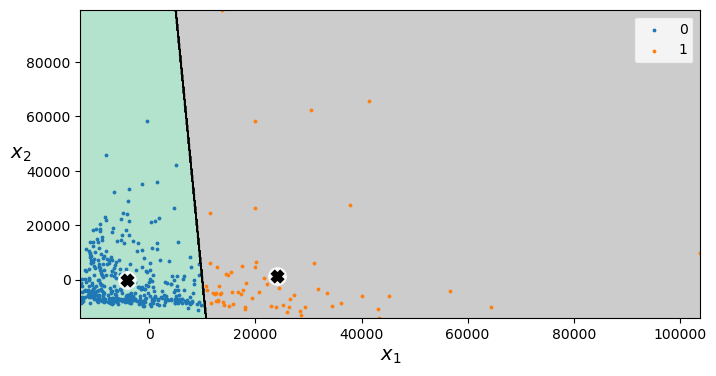

In [11]:
kmeans_2 = KMeans(n_clusters=2, n_init=10, random_state=0).fit(data_pca)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_2, data_pca)
plt.show();

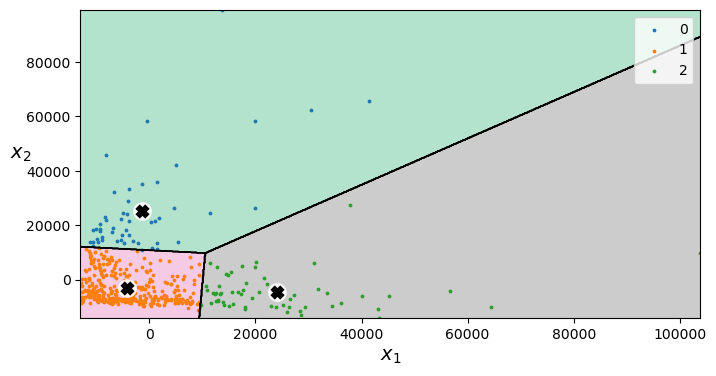

In [12]:
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(data_pca)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_3, data_pca)
plt.show()

# 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [13]:
cluster = full_df[['Region', 'Channel']]
cluster

,Region,Channel
0,3,2
1,3,2
2,3,2
3,3,1
4,3,2
...,...,...
435,3,1
436,3,1
437,3,2
438,3,1


## Region

In [14]:
cluster['Region'].unique()

array([3, 1, 2])

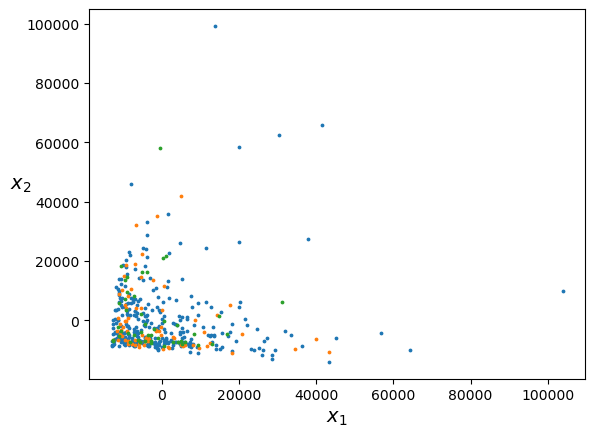

In [15]:
for i in (cluster['Region'].unique()):
    in_cluster = cluster['Region'] == i
    plt.scatter(data_pca[in_cluster][:, 0], data_pca[in_cluster][:, 1], s=3) 
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0) 
plt.show();

Region毎にプロットすると85％ほどの主成分分析した後のデータでは特に関係性は見いだせない。  
15％に落ちていて、２次元じゃ可視化できない可能性が高いと思われる。

## Channel

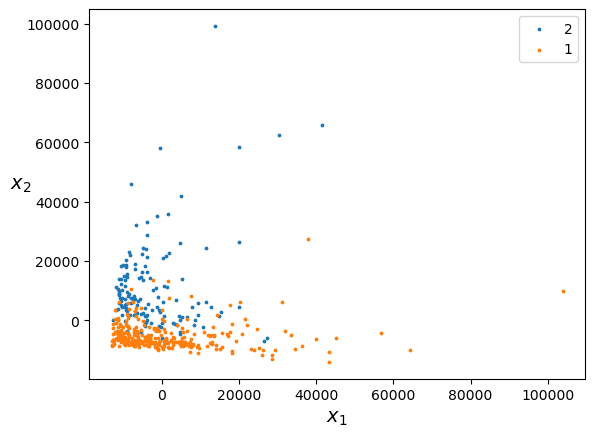

In [16]:
for i in (cluster['Channel'].unique()):
    in_cluster = cluster['Channel'] == i
    plt.scatter(data_pca[in_cluster][:, 0], data_pca[in_cluster][:, 1], s=3, label=i) 
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.legend()
plt.show();

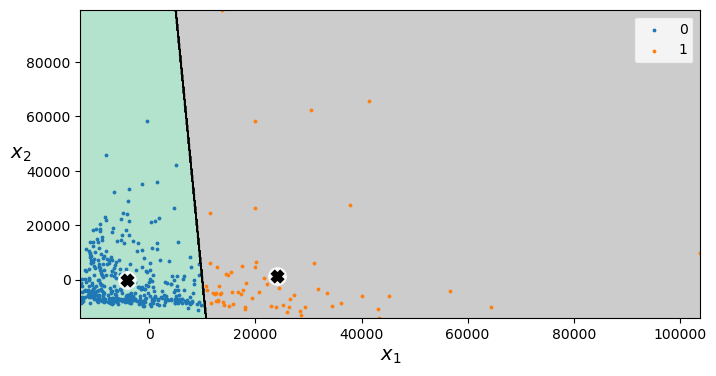

In [17]:
kmeans_2 = KMeans(n_clusters=2, n_init=10, random_state=0).fit(data_pca)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_2, data_pca)
plt.show()

Channelラベルでの分け方は$X_2$の値っぽいがKmeansは距離を見てるので分割できない  
X_2が何かと言われても説明はできないが、第二主成分

# 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。


《ヒント》
前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。
条件ごとにデータを見る際にはPandasのgroupbyが便利です。

## ６個のデータのまま使用

In [18]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data_df)
                for k in range(2, 30)]
inertias = [model.inertia_ for model in kmeans_per_k]

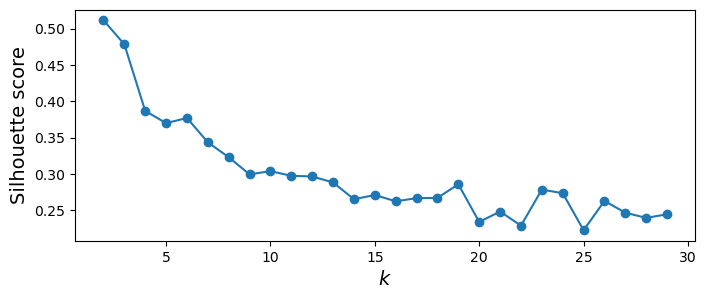

In [19]:
silhouette_scores = [silhouette_score(data_df, model.labels_)
                     for model in kmeans_per_k]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 30), silhouette_scores, marker='o')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show();

特徴量を次元削減していなくても、最適クラスタは２個

In [20]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(data_df)

KMeans(n_clusters=2, random_state=0)

In [21]:
cluster_0 = data_df[0 == kmeans.labels_]
cluster_1 = data_df[1 == kmeans.labels_]

In [22]:
cluster_0.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000
mean,7944.112000,5151.818667,7536.128000,2484.130667,2872.557333,1214.261333
std,6123.004257,5239.026007,8103.220931,3267.973087,4273.292056,1341.346213
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,2779.000000,1455.500000,2068.500000,661.500000,256.000000,387.000000
50%,6758.000000,3354.000000,4563.000000,1383.000000,836.000000,806.000000
75%,11887.500000,6995.500000,10582.000000,3010.000000,4084.500000,1626.000000
max,23257.000000,29892.000000,67298.000000,35009.000000,38102.000000,14472.000000


In [23]:
cluster_1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,35401.369231,9514.230769,10346.369231,6463.092308,2933.046154,3316.846154
std,15017.755539,14027.170218,15130.151804,9249.184773,7015.288413,6341.278125
min,16117.000000,286.000000,471.000000,42.000000,10.000000,3.000000
25%,25977.000000,2567.000000,2961.000000,1364.000000,284.000000,1022.000000
50%,30624.000000,4411.000000,5428.000000,3443.000000,632.000000,1824.000000
75%,40254.000000,8384.000000,10790.000000,8620.000000,1579.000000,2931.000000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


cluster_1に分類された人は購入量がcluster_0に分類された人たちよりも多い  
つまり、X_1は購入量と同じような指標だとかんがえられる。

In [24]:
channel_1 = data_df[1 == full_df['Channel']]
channel_2 = data_df[2 == full_df['Channel']]

In [25]:
channel_1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
std,13831.687502,4352.165571,3545.513391,5643.912500,1104.093673,3147.426922
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,4070.250000,1164.500000,1703.750000,830.000000,183.250000,379.000000
50%,9581.500000,2157.000000,2684.000000,2057.500000,385.500000,821.000000
75%,18274.750000,4029.500000,5076.750000,4558.750000,899.500000,1548.000000
max,112151.000000,43950.000000,21042.000000,60869.000000,6907.000000,47943.000000


In [26]:
channel_2.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620
std,8987.714750,9679.631351,12267.318094,1812.803662,6291.089697,1953.797047
min,18.000000,928.000000,2743.000000,33.000000,332.000000,3.000000
25%,2347.750000,5938.000000,9245.250000,534.250000,3683.500000,566.750000
50%,5993.500000,7812.000000,12390.000000,1081.000000,5614.500000,1350.000000
75%,12229.750000,12162.750000,20183.500000,2146.750000,8662.500000,2156.000000
max,44466.000000,73498.000000,92780.000000,11559.000000,40827.000000,16523.000000


Channelの分類方法はMilk,Grocery,Detergents_Paperの3項目で大きな違いが生じでいる。  
また、主成分分析した後の図をみるとCannel_1に分類されている人はX_2が低く、X_2はこの3項目の購入量に近い指標になると考えられる。  
## クラスターを3つに分けると

In [27]:
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(data_pca)
kmeans_3.fit(data_df)
cluster_0 = data_df[0 == kmeans_3.labels_]
cluster_1 = data_df[1 == kmeans_3.labels_]
cluster_2 = data_df[2 == kmeans_3.labels_]

In [28]:
cluster_0.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,7751.981132,17910.509434,27037.905660,1970.943396,12104.867925,2185.735849
std,8971.193466,12888.506152,14280.589441,2029.579943,7897.636314,2628.169692
min,37.000000,1275.000000,13567.000000,33.000000,282.000000,3.000000
25%,1420.000000,10810.000000,19460.000000,787.000000,7108.000000,716.000000
50%,5283.000000,14069.000000,22272.000000,1274.000000,9836.000000,1423.000000
75%,10683.000000,21858.000000,28921.000000,2616.000000,14235.000000,2563.000000
max,44466.000000,73498.000000,92780.000000,10155.000000,40827.000000,16523.000000


In [29]:
cluster_1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,8341.612805,3779.893293,5152.173780,2577.237805,1720.573171,1136.542683
std,6239.384063,3148.534522,4201.722806,3413.101478,2133.026387,1282.351910
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,2916.000000,1283.250000,1994.750000,660.750000,232.000000,370.000000
50%,7211.500000,2795.000000,3414.500000,1386.000000,624.000000,761.000000
75%,12492.750000,5569.000000,7654.500000,3143.500000,2785.250000,1536.000000
max,23257.000000,18664.000000,21042.000000,35009.000000,10069.000000,14472.000000


In [30]:
cluster_2.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,36156.389831,6123.644068,6366.779661,6811.118644,1050.016949,3090.050847
std,15273.600528,7089.170976,4628.662520,9607.250402,1310.901499,6402.199577
min,22096.000000,286.000000,471.000000,127.000000,10.000000,3.000000
25%,26469.500000,2217.500000,2628.500000,1376.500000,261.500000,991.000000
50%,31012.000000,3965.000000,5091.000000,3881.000000,523.000000,1621.000000
75%,40487.500000,7168.000000,8266.500000,9050.000000,1126.000000,2884.500000
max,112151.000000,43950.000000,20170.000000,60869.000000,5058.000000,47943.000000


cluster_0に分類されたデータは、channel_0と近い
また、cluster_0をみてもMilk,Grocery,Detergents_Paperの3項目は高く、X_2はそれに関係する指標だと決定づけられる。  
***つまり、その3項目だけを多く買う層が５３人存在する事を示している。***

# 【問題13】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。


DBSCANのメリット・デメリット
t-SNE、LLEのメリット・デメリット

について記述してください

## DBSCAN

epsで定めた距離の間にmin_sanple個のインスタンスがあれば、そのインスタンスをコアインスタンスとして定める。  
コアインスタンスは連結し、コアインスタンスでなく近くにコアインスタンスがないインスタンスは異常値としてみなされる。  
クラスタ間の密度が等しいのあれば、任意の形の任意の個数のクラスタを見分けられる方法  
predictがなく、もし行う場合はKNNを使用する。

## LLE

スイスロールデータセットの様にどの様にPCAを用いてしてもうまく次元削減できない場合にも使用できる主成分分析  
理論としては、ある点Xを近傍の点（数は任意）で表現すると言った物  


$$\displaystyle \sum_j w_{j} {\bf x_j} = w_1{\bf x_1} + w_K{\bf x_K}$$
$$\displaystyle \left| {\bf x} - \sum_{{\bf x_j} \in \mathcal K} w_j {\bf x_j} \right|^2$$

このwををMSEで最小化する。  
それによって平面で考えるのではなくノルムで考えるので、次元削減が可能  

欠点としては少数の近傍の点で表現する事となるため、局所的な次元削減となる。

![Imgur](https://i.imgur.com/eIKis23h.png)
![Imgur](https://i.imgur.com/MwJ8gkdh.png)

## T-SNE

主成分分析のデメリットである線形曲線が弾けないデータ  
LLSの局所的な次元削減になってしまう  
の両方を克服した手法

各点と他の点への距離が正規分布に則ると仮定するのであれば、
$$p_{j|i} = \frac{\exp(-||x_{i} - x_{j}||^2/2\sigma_{i}^2)}{\sum_{k\neq i}\exp(-||x_{i} - x_{k}||^2/2\sigma_{i}^2)}$$
が成立する。(下の式は選択点以外)

これを次元を下げた場合にプロットすると

$$q_{j|i} = \frac{\exp(-||y_{i} - y_{j}||^2)}{\sum_{k\neq i}\exp(-||y_{i} - y_{k}||^2)}$$

となる。この誤差をKL情報量を損失関数にして、確率的勾配降下法で低次元に射影した時の座標を求める。  
ここで問題
1. 損失関数が複雑（非対称）
2. Crowding問題  
が発生するため、正規分布ではなくT分布で最小化した物

Crowding問題  
多次元のものを低次元に落とし込んだ時に、お互いに等距離であれるデータポイントの数が減少するため、次元を落とす時に等距離性を保とうとして混雑化してしまうという問題

例えば3次元であれば次元数＋1の4つのデータポイントが互いに等距離で存在できるが、2次元に落とすと次元数＋1の3つしか等距離、次元数を落とした時に本来発生するはずの隙間を潰してしまう可能性をCrowding問題と呼ぶ

## 【問題14】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。


そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。
## T-SNE

In [31]:
from sklearn.manifold import TSNE
data_tsne = TSNE(n_components=2, random_state=0).fit_transform(data_df)

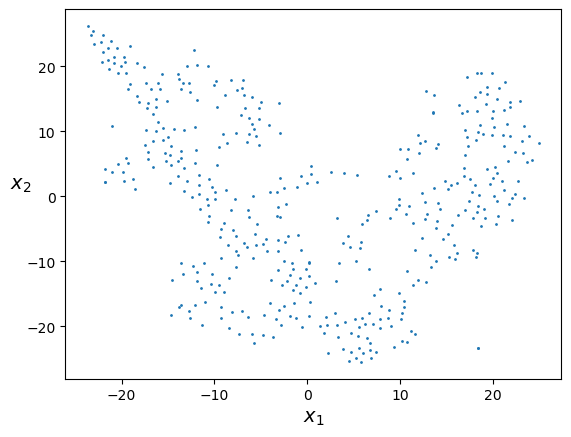

<Figure size 800x400 with 0 Axes>

In [32]:
plot_clusters(data_tsne)
plt.show();

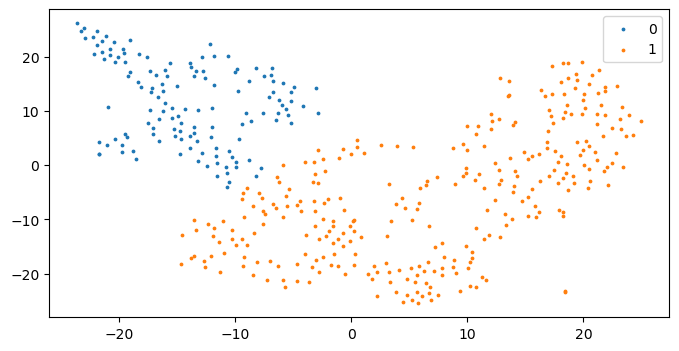

In [33]:
kmeans_2 = KMeans(n_clusters=2, n_init=10, random_state=0).fit(data_tsne)
plt.figure(figsize=(8, 4))
plot_data(kmeans_2, data_tsne)
plt.show();

In [34]:
cluster_0 = data_df[0 == kmeans_2.labels_]
cluster_1 = data_df[1 == kmeans_2.labels_]

In [35]:
cluster_0.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,25351.191176,3928.022059,5184.705882,4377.139706,1133.683824,1767.110294
std,13906.877945,3906.735582,4325.123479,6335.314067,1591.195422,2107.646069
min,1989.000000,134.000000,3.000000,118.000000,3.000000,3.000000
25%,17012.250000,1375.750000,2011.250000,1054.750000,211.500000,596.000000
50%,20905.500000,2878.000000,3711.000000,2524.000000,519.500000,1160.500000
75%,29652.000000,5013.750000,7310.250000,5350.500000,1367.250000,2239.500000
max,112151.000000,29627.000000,21042.000000,60869.000000,11577.000000,14472.000000


In [36]:
channel_1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
std,13831.687502,4352.165571,3545.513391,5643.912500,1104.093673,3147.426922
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,4070.250000,1164.500000,1703.750000,830.000000,183.250000,379.000000
50%,9581.500000,2157.000000,2684.000000,2057.500000,385.500000,821.000000
75%,18274.750000,4029.500000,5076.750000,4558.750000,899.500000,1548.000000
max,112151.000000,43950.000000,21042.000000,60869.000000,6907.000000,47943.000000


T-SNEで分析すると、購入量で分別している事に変わりはないが差が少なく見える。

## DBSCAN
### PCA

In [37]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=4000, min_samples=5).fit(data_pca)
dbs.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,
        0,  1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1, -1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0

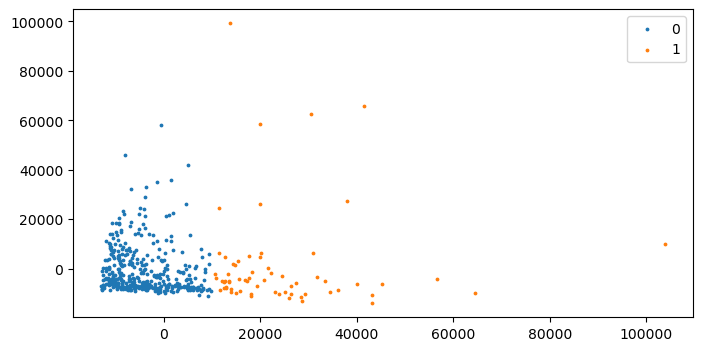

In [40]:
kmeans_2 = KMeans(n_clusters=2, n_init=10, random_state=0).fit(data_pca)
plt.figure(figsize=(8, 4))
plot_data(kmeans_2, data_pca)
plt.show();

DBSCANは各ノードの距離で計算するので今回のPCAのプロットでは密度が濃すぎて正常に分析できなかった。

### T-SNE

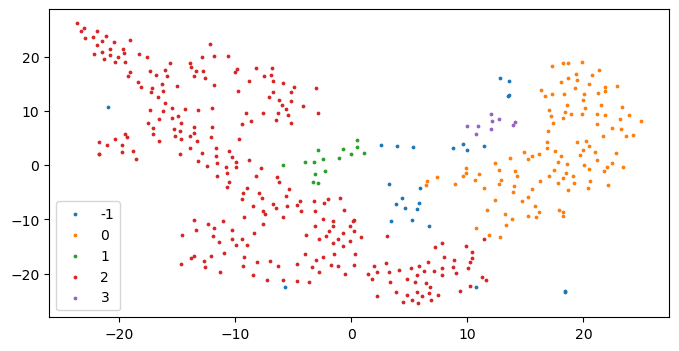

In [58]:
dbs = DBSCAN(eps=3, min_samples=8).fit(data_tsne)
plt.figure(figsize=(8, 4))
plot_data(dbs, data_tsne)
plt.show();

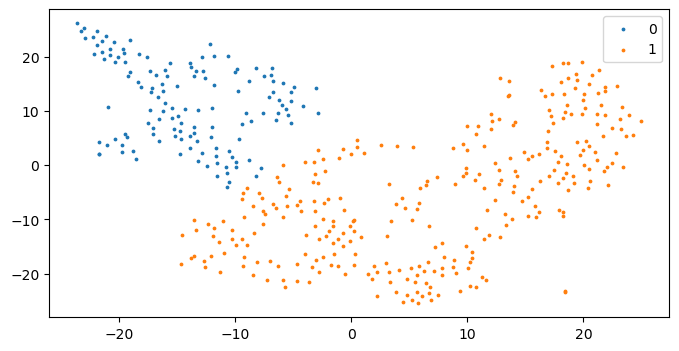

In [59]:
kmeans_2 = KMeans(n_clusters=2, n_init=10, random_state=0).fit(data_tsne)
plt.figure(figsize=(8, 4))
plot_data(kmeans_2, data_tsne)
plt.show();

In [61]:
cluster_0 = data_df[0 == dbs.labels_]
cluster_1 = data_df[1 == dbs.labels_]
cluster_2 = data_df[2 == dbs.labels_]
cluster_3 = data_df[3 == dbs.labels_]

In [62]:
cluster_0.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,4619.313559,11291.957627,17249.093220,1385.966102,7773.822034,1529.533898
std,6219.612452,10134.222497,13074.654226,1523.329265,6690.617140,1537.498099
min,9.000000,1275.000000,1660.000000,25.000000,93.000000,3.000000
25%,1033.250000,5759.250000,9490.000000,337.000000,3878.250000,445.250000
50%,3077.000000,8445.500000,13100.500000,932.000000,5967.000000,1139.000000
75%,5607.000000,12861.250000,21560.250000,1740.750000,9182.000000,1872.250000
max,44466.000000,73498.000000,92780.000000,7782.000000,40827.000000,7844.000000


In [65]:
channel_2.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620
std,8987.714750,9679.631351,12267.318094,1812.803662,6291.089697,1953.797047
min,18.000000,928.000000,2743.000000,33.000000,332.000000,3.000000
25%,2347.750000,5938.000000,9245.250000,534.250000,3683.500000,566.750000
50%,5993.500000,7812.000000,12390.000000,1081.000000,5614.500000,1350.000000
75%,12229.750000,12162.750000,20183.500000,2146.750000,8662.500000,2156.000000
max,44466.000000,73498.000000,92780.000000,11559.000000,40827.000000,16523.000000


一番サンプル数が多そうなDBSCANでの分類クラスタを見てみたが、明確なちがいはわからなかった。  
種類によって平均値が若干違ったりするので、その特徴になっているのか...

In [66]:
cluster_0 = data_df[0 == kmeans_2.labels_]
cluster_1 = data_df[1 == kmeans_2.labels_]

In [68]:
cluster_0.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,25351.191176,3928.022059,5184.705882,4377.139706,1133.683824,1767.110294
std,13906.877945,3906.735582,4325.123479,6335.314067,1591.195422,2107.646069
min,1989.000000,134.000000,3.000000,118.000000,3.000000,3.000000
25%,17012.250000,1375.750000,2011.250000,1054.750000,211.500000,596.000000
50%,20905.500000,2878.000000,3711.000000,2524.000000,519.500000,1160.500000
75%,29652.000000,5013.750000,7310.250000,5350.500000,1367.250000,2239.500000
max,112151.000000,29627.000000,21042.000000,60869.000000,11577.000000,14472.000000


In [69]:
cluster_1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,6027.529605,6632.059211,9188.953947,2488.023026,3663.407895,1416.500000
std,5457.503350,8357.684952,10841.510312,3893.197129,5461.056813,3083.075254
min,3.000000,55.000000,137.000000,25.000000,5.000000,3.000000
25%,2149.000000,1661.500000,2212.250000,571.500000,274.750000,356.750000
50%,5202.500000,3840.500000,5257.000000,1254.000000,1193.000000,819.500000
75%,8867.000000,8338.250000,12126.750000,2782.000000,5089.500000,1639.500000
max,44466.000000,73498.000000,92780.000000,36534.000000,40827.000000,47943.000000


cluster_1をみるとMilk,Grocery,Detergents_Paperの3項目圧倒的に高く、X-1はその指標だと説明できる。  